# EDA

In [2]:
import pyreadr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Pubmed Dataset 

In [3]:
pubmed = pyreadr.read_r('data/raw/pubmed.rds')
pubmed_df = list(pubmed.values())[0]
pubmed_df.head()

,PMID,Title,Abstract,Journal,Authors
0,15165820,"Comparative genomic analyses of frog virus 3, ...",Frog virus 3 (FV3) is the type species member ...,Virology,"Wendy G H Tan, Todd J Barkman, V Gregory Chinc..."
1,16912294,Genome of invertebrate iridescent virus type 3...,Iridoviruses (IVs) are classified into five ge...,Journal of virology,"Gustavo Delhon, Edan R Tulman, Claudio L Afons..."
2,11448171,Analysis of the first complete DNA sequence of...,"Chilo iridescent virus (CIV), the type species...",Virology,"N J Jakob, K Müller, U Bahr, G Darai"
3,17239238,Comparative genomic analysis of the family Iri...,Members of the family Iridoviridae can cause s...,Virology journal,"Heather E Eaton, Julie Metcalf, Emily Penny, V..."
4,20633916,"Frog virus 3 ORF 53R, a putative myristoylated...",Although previous work identified 12 complemen...,Virology,"Dexter S Whitley, Kwang Yu, Robert C Sample, A..."


In [4]:
# Find the shape of the dataframe
pubmed_df.shape

(262819, 5)

In [5]:
# Find the column names of the dataframe
pubmed_df.columns.tolist()

['PMID', 'Title', 'Abstract', 'Journal', 'Authors']

In [6]:
# Find Shape
pubmed_df.dtypes

PMID         int32
Title       object
Abstract    object
Journal     object
Authors     object
dtype: object

In [7]:
# Find Missing Values
pubmed_df.isnull().sum()

PMID           0
Title          0
Abstract    8607
Journal        0
Authors        0
dtype: int64

In [8]:
PM_dup = pubmed_df[pubmed_df.duplicated('PMID', keep=False)].sort_values('PMID')
PM_dup.shape

(0, 5)

## Autoregulatory 

In [9]:
autoreg = pyreadr.read_r('data/raw/autoregulatoryDB.rds')
autoreg_df = list(autoreg.values())[0]
autoreg_df.head()

,AC,OS,RN,RP,RC,RX,RG,RA,RT,RL,Term_in_RP,Term_in_RT,Term_in_RC
0,Q6GZX4,Frog virus 3 (isolate Goorha) (FV-3),[1],NUCLEOTIDE SEQUENCE [LARGE SCALE GENOMIC DNA].,NaN,PubMed=15165820; DOI=10.1016/j.virol.2004.02.019;,NaN,"Tan W.G., Barkman T.J., Gregory Chinchar V., E...","""Comparative genomic analyses of frog virus 3,...",Virology 323:70-84(2004).,,,
1,Q6GZX3,Frog virus 3 (isolate Goorha) (FV-3),[1],NUCLEOTIDE SEQUENCE [LARGE SCALE GENOMIC DNA].,NaN,PubMed=15165820; DOI=10.1016/j.virol.2004.02.019;,NaN,"Tan W.G., Barkman T.J., Gregory Chinchar V., E...","""Comparative genomic analyses of frog virus 3,...",Virology 323:70-84(2004).,,,
2,Q197F8,Invertebrate iridescent virus 3 (IIV-3) (Mosqu...,[1],NUCLEOTIDE SEQUENCE [LARGE SCALE GENOMIC DNA].,NaN,PubMed=16912294; DOI=10.1128/jvi.00464-06;,NaN,"Delhon G., Tulman E.R., Afonso C.L., Lu Z., Be...","""Genome of invertebrate iridescent virus type ...",J. Virol. 80:8439-8449(2006).,,,
3,Q197F7,Invertebrate iridescent virus 3 (IIV-3) (Mosqu...,[1],NUCLEOTIDE SEQUENCE [LARGE SCALE GENOMIC DNA].,NaN,PubMed=16912294; DOI=10.1128/jvi.00464-06;,NaN,"Delhon G., Tulman E.R., Afonso C.L., Lu Z., Be...","""Genome of invertebrate iridescent virus type ...",J. Virol. 80:8439-8449(2006).,,,
4,Q6GZX2,Frog virus 3 (isolate Goorha) (FV-3),[1],NUCLEOTIDE SEQUENCE [LARGE SCALE GENOMIC DNA].,NaN,PubMed=15165820; DOI=10.1016/j.virol.2004.02.019;,NaN,"Tan W.G., Barkman T.J., Gregory Chinchar V., E...","""Comparative genomic analyses of frog virus 3,...",Virology 323:70-84(2004).,,,


In [10]:
# Find the shape of the dataframe
autoreg_df.shape

(1323976, 13)

In [11]:
# Find the column names of the dataframe
autoreg_df.columns.tolist()

['AC',
 'OS',
 'RN',
 'RP',
 'RC',
 'RX',
 'RG',
 'RA',
 'RT',
 'RL',
 'Term_in_RP',
 'Term_in_RT',
 'Term_in_RC']

In [12]:
# Find data types
autoreg_df.dtypes

AC            object
OS            object
RN            object
RP            object
RC            object
RX            object
RG            object
RA            object
RT            object
RL            object
Term_in_RP    object
Term_in_RT    object
Term_in_RC    object
dtype: object

In [13]:
autoreg_df['PMID'] = autoreg_df['RX'].str.extract(r'PubMed=(\d+)', expand=False)
autoreg_df['PMID'] = pd.to_numeric(autoreg_df['PMID'], errors='coerce')

In [14]:
# Find Missing Values
autoreg_df.isnull().sum()

AC                  0
OS                  0
RN                  0
RP                  0
RC             511667
RX             178720
RG            1210925
RA              68817
RT              56058
RL                  0
Term_in_RP          0
Term_in_RT          0
Term_in_RC          0
PMID           181779
dtype: int64

In [15]:
def merge_terms(row):
    cols = ['Term_in_RP', 'Term_in_RT', 'Term_in_RC']
    terms = []
    for col in cols:
        val = row[col]
        if pd.notna(val):
            split_terms = [t.strip() for t in str(val).split(',') if t.strip()]
            terms.extend(split_terms)
    return ', '.join(sorted(set(terms))) if terms else ''

autoreg_df['Terms'] = autoreg_df.apply(merge_terms, axis=1)

In [16]:
labeled = sum((autoreg_df['Terms'].notna()) & (autoreg_df['Terms'] != ''))
unlabeled = len(autoreg_df) - labeled
print(f'Labeled: {labeled}, Unlabeled: {unlabeled}')
labeled/unlabeled * 100

Labeled: 1823, Unlabeled: 1322153


0.13788116806451298

In [17]:
AR_dup = autoreg_df[autoreg_df.duplicated('PMID', keep=False)].sort_values('PMID')
AR_dup.shape

(1144977, 15)

In [18]:
# How many of the missing PMIDs actually have labels?
missing_pmid_with_labels = autoreg_df[(autoreg_df['PMID'].isna()) & 
                                       (autoreg_df['Terms'] != '')].shape[0]
print(f"Labeled rows we're losing: {missing_pmid_with_labels}")

Labeled rows we're losing: 10


## Data Cleaning

In [19]:
autoreg_df.head()

,AC,OS,RN,RP,RC,RX,RG,RA,RT,RL,Term_in_RP,Term_in_RT,Term_in_RC,PMID,Terms
0,Q6GZX4,Frog virus 3 (isolate Goorha) (FV-3),[1],NUCLEOTIDE SEQUENCE [LARGE SCALE GENOMIC DNA].,NaN,PubMed=15165820; DOI=10.1016/j.virol.2004.02.019;,NaN,"Tan W.G., Barkman T.J., Gregory Chinchar V., E...","""Comparative genomic analyses of frog virus 3,...",Virology 323:70-84(2004).,,,,15165820.0,
1,Q6GZX3,Frog virus 3 (isolate Goorha) (FV-3),[1],NUCLEOTIDE SEQUENCE [LARGE SCALE GENOMIC DNA].,NaN,PubMed=15165820; DOI=10.1016/j.virol.2004.02.019;,NaN,"Tan W.G., Barkman T.J., Gregory Chinchar V., E...","""Comparative genomic analyses of frog virus 3,...",Virology 323:70-84(2004).,,,,15165820.0,
2,Q197F8,Invertebrate iridescent virus 3 (IIV-3) (Mosqu...,[1],NUCLEOTIDE SEQUENCE [LARGE SCALE GENOMIC DNA].,NaN,PubMed=16912294; DOI=10.1128/jvi.00464-06;,NaN,"Delhon G., Tulman E.R., Afonso C.L., Lu Z., Be...","""Genome of invertebrate iridescent virus type ...",J. Virol. 80:8439-8449(2006).,,,,16912294.0,
3,Q197F7,Invertebrate iridescent virus 3 (IIV-3) (Mosqu...,[1],NUCLEOTIDE SEQUENCE [LARGE SCALE GENOMIC DNA].,NaN,PubMed=16912294; DOI=10.1128/jvi.00464-06;,NaN,"Delhon G., Tulman E.R., Afonso C.L., Lu Z., Be...","""Genome of invertebrate iridescent virus type ...",J. Virol. 80:8439-8449(2006).,,,,16912294.0,
4,Q6GZX2,Frog virus 3 (isolate Goorha) (FV-3),[1],NUCLEOTIDE SEQUENCE [LARGE SCALE GENOMIC DNA].,NaN,PubMed=15165820; DOI=10.1016/j.virol.2004.02.019;,NaN,"Tan W.G., Barkman T.J., Gregory Chinchar V., E...","""Comparative genomic analyses of frog virus 3,...",Virology 323:70-84(2004).,,,,15165820.0,


In [20]:
# Drop Autoreg rows with missing PMIDs
autoreg_df = autoreg_df.dropna(subset=['PMID'])



## Merge Datasets

In [21]:
# Aggregate the 'Terms' column by PMID, merging multiple protein entries per paper
autoreg_aggregated = (
    autoreg_df.groupby('PMID', as_index=False)
    .agg({
        'Terms': lambda x: ', '.join(sorted(set(
            term.strip()
            for terms_str in x
            for term in str(terms_str).split(',')
            if term.strip()  # remove empty or whitespace-only strings
        )))
    })
)

# Create a binary flag showing whether a paper has any mechanism terms
autoreg_aggregated['has_mechanism'] = autoreg_aggregated['Terms'] != ''



In [22]:

summary = {
    "before_rows": len(autoreg_df),
    "after_rows": len(autoreg_aggregated),
    "with_labels": autoreg_aggregated['has_mechanism'].sum(),
    "without_labels": (~autoreg_aggregated['has_mechanism']).sum()
}
summary


{'before_rows': 1142197,
 'after_rows': 268619,
 'with_labels': 1374,
 'without_labels': 267245}

In [23]:
# Ensure PMID columns have the same numeric type for merging
pubmed_df['PMID'] = pubmed_df['PMID'].astype('int64')
autoreg_aggregated['PMID'] = autoreg_aggregated['PMID'].astype('int64')

# Perform a left join to keep all PubMed entries, adding label info when available
merged_df = pubmed_df.merge(
    autoreg_aggregated[['PMID', 'Terms', 'has_mechanism']],
    on='PMID',
    how='left'
)

# Fill missing label info: empty string for Terms, False for has_mechanism
merged_df['Terms'] = merged_df['Terms'].fillna('')
merged_df['has_mechanism'] = merged_df['has_mechanism'].fillna(False)


In [24]:

# Create a small summary dictionary instead of multiple print statements
merge_summary = {
    "total_papers": len(merged_df),
    "labeled_papers": int(merged_df['has_mechanism'].sum()),
    "unlabeled_papers": int((~merged_df['has_mechanism']).sum()),
    "percent_labeled": merged_df['has_mechanism'].mean() * 100
}

merge_summary


{'total_papers': 262819,
 'labeled_papers': 1349,
 'unlabeled_papers': 261470,
 'percent_labeled': 0.5132810032760189}

In [25]:
# Compare before/after
print(f"\nLabels in original autoreg (after dropping missing PMID): {(autoreg_df['Terms'] != '').sum()}")
print(f"Labels after aggregation: {autoreg_aggregated['has_mechanism'].sum()}")
print(f"Labels after merge with PubMed: {merged_df['has_mechanism'].sum()}")

labels_lost = (autoreg_df['Terms'] != '').sum() - merged_df['has_mechanism'].sum()
print(f"\nTotal labels lost: {labels_lost}")




Labels in original autoreg (after dropping missing PMID): 1813
Labels after aggregation: 1374
Labels after merge with PubMed: 1349

Total labels lost: 464


In [26]:
# See which labeled papers from autoreg are NOT in PubMed
autoreg_labeled_pmids = set(autoreg_aggregated[autoreg_aggregated['has_mechanism']]['PMID'])
pubmed_pmids = set(pubmed_df['PMID'])
missing_from_pubmed = autoreg_labeled_pmids - pubmed_pmids

print(f"\nLabeled papers NOT in PubMed: {len(missing_from_pubmed)}")
if len(missing_from_pubmed) > 0:
    print(f"Example missing PMIDs: {list(missing_from_pubmed)[:10]}")


Labeled papers NOT in PubMed: 25
Example missing PMIDs: [23661702, 18557704, 20956560, 23453972, 9434772, 26611359, 21145761, 20022946, 12582180, 19141286]


In [27]:
merged_df.head()

,PMID,Title,Abstract,Journal,Authors,Terms,has_mechanism
0,15165820,"Comparative genomic analyses of frog virus 3, ...",Frog virus 3 (FV3) is the type species member ...,Virology,"Wendy G H Tan, Todd J Barkman, V Gregory Chinc...",,False
1,16912294,Genome of invertebrate iridescent virus type 3...,Iridoviruses (IVs) are classified into five ge...,Journal of virology,"Gustavo Delhon, Edan R Tulman, Claudio L Afons...",,False
2,11448171,Analysis of the first complete DNA sequence of...,"Chilo iridescent virus (CIV), the type species...",Virology,"N J Jakob, K Müller, U Bahr, G Darai",,False
3,17239238,Comparative genomic analysis of the family Iri...,Members of the family Iridoviridae can cause s...,Virology journal,"Heather E Eaton, Julie Metcalf, Emily Penny, V...",,False
4,20633916,"Frog virus 3 ORF 53R, a putative myristoylated...",Although previous work identified 12 complemen...,Virology,"Dexter S Whitley, Kwang Yu, Robert C Sample, A...",,False


In [28]:
# Check how many LABELED papers are missing abstracts
labeled_subset = merged_df[merged_df['has_mechanism'] == True]
missing_abstract_labeled = labeled_subset['Abstract'].isna().sum()

print(f"\nLabeled papers missing abstracts: {missing_abstract_labeled}")
print(f"That's {missing_abstract_labeled/len(labeled_subset)*100:.1f}% of labeled data")

# If it's small (< 30), drop them
if missing_abstract_labeled < 30:
    print(f"\n✓ Dropping {missing_abstract_labeled} labeled papers with no abstract")
    merged_df = merged_df[merged_df['Abstract'].notna()]
    print(f"Dataset after dropping: {len(merged_df)} papers")
    print(f"Labeled papers remaining: {merged_df['has_mechanism'].sum()}")
else:
    print(f"\n⚠️  Many labeled papers missing abstracts - need to decide!")
    print("Options: 1) Use title-only for these, 2) Drop them")


Labeled papers missing abstracts: 2
That's 0.1% of labeled data

✓ Dropping 2 labeled papers with no abstract
Dataset after dropping: 254212 papers
Labeled papers remaining: 1347


In [29]:
merged_df['text'] = (merged_df['Title'].fillna('') + '. ' + 
                     merged_df['Abstract'].fillna(''))
merged_df['text_length'] = merged_df['text'].str.len()

In [30]:
print("✓ Created combined text column")
print(f"\nText length stats:")
print(merged_df['text_length'].describe())

✓ Created combined text column

Text length stats:
count    254212.000000
mean       1348.129778
std         432.347823
min          87.000000
25%        1068.000000
50%        1351.000000
75%        1635.000000
max        4911.000000
Name: text_length, dtype: float64


In [31]:
# THE MOST IMPORTANT ANALYSIS - Which terms can you learn?
all_terms = []
for terms_str in merged_df[merged_df['has_mechanism']]['Terms']:
    if pd.notna(terms_str) and terms_str != '':
        terms_list = [t.strip() for t in str(terms_str).split(',')]
        all_terms.extend(terms_list)

term_counts = pd.Series(all_terms).value_counts()

print("\n" + "="*50)
print("TERM DISTRIBUTION")
print("="*50)
print(term_counts)

# Imbalance ratio
print(f"\nImbalance ratio: {term_counts.max() / term_counts.min():.1f}:1")

# Categorize
print(f"\n✓ Common terms (>100 examples): {len(term_counts[term_counts >= 100])}")
print(term_counts[term_counts >= 100])

print(f"\n⚠️  Rare terms (<50 examples): {len(term_counts[term_counts < 50])}")
print(term_counts[term_counts < 50])


TERM DISTRIBUTION
autophosphorylation    719
autocatalytic          133
autoubiquitination     121
autoregulation         119
autoinhibition          84
autoregulatory          44
autoinhibitory          43
autolysis               41
autoinducer             31
autoactivation          17
autocatalysis           14
autoinduction            7
autokinase               5
autofeedback             2
autophosphatase          1
Name: count, dtype: int64

Imbalance ratio: 719.0:1

✓ Common terms (>100 examples): 4
autophosphorylation    719
autocatalytic          133
autoubiquitination     121
autoregulation         119
Name: count, dtype: int64

⚠️  Rare terms (<50 examples): 10
autoregulatory     44
autoinhibitory     43
autolysis          41
autoinducer        31
autoactivation     17
autocatalysis      14
autoinduction       7
autokinase          5
autofeedback        2
autophosphatase     1
Name: count, dtype: int64


In [32]:
def normalize_terms(terms):
    """
    Normalize similar terms to their most common form
    """
    if pd.isna(terms) or terms == '':
        return terms
    
    # Map TO the more common form (the one with more examples)
    normalization_rules = {
        # autoregulation group (119 + 44 = 163)
        'autoregulatory': 'autoregulation',
        
        # autoinhibition group (84 + 43 = 127)
        'autoinhibitory': 'autoinhibition',
        
        # autocatalytic group (133 + 14 = 147)
        'autocatalysis': 'autocatalytic',
        
        # autoinducer group (31 + 7 = 38)
        'autoinduction': 'autoinducer',
        
        # Optional: combine very rare with related
        'autokinase': 'autophosphorylation',  # 5 → 719 (kinase IS phosphorylation)
        'autophosphatase': 'autophosphorylation',  # 1 → 719 (related to phosphorylation)
    }
    
    normalized_terms = []
    for term in terms.split(','):
        term = term.strip().lower()
        normalized_term = normalization_rules.get(term, term)
        normalized_terms.append(normalized_term)
    
    return ', '.join(sorted(set(normalized_terms)))

# Apply normalization
merged_df['Terms_normalized'] = merged_df['Terms'].apply(normalize_terms)
merged_df['has_mechanism_norm'] = (merged_df['Terms_normalized'] != '')

In [33]:
merged_df.head()

,PMID,Title,Abstract,Journal,Authors,Terms,has_mechanism,text,text_length,Terms_normalized,has_mechanism_norm
0,15165820,"Comparative genomic analyses of frog virus 3, ...",Frog virus 3 (FV3) is the type species member ...,Virology,"Wendy G H Tan, Todd J Barkman, V Gregory Chinc...",,False,"Comparative genomic analyses of frog virus 3, ...",971,,False
1,16912294,Genome of invertebrate iridescent virus type 3...,Iridoviruses (IVs) are classified into five ge...,Journal of virology,"Gustavo Delhon, Edan R Tulman, Claudio L Afons...",,False,Genome of invertebrate iridescent virus type 3...,1970,,False
2,11448171,Analysis of the first complete DNA sequence of...,"Chilo iridescent virus (CIV), the type species...",Virology,"N J Jakob, K Müller, U Bahr, G Darai",,False,Analysis of the first complete DNA sequence of...,2164,,False
3,17239238,Comparative genomic analysis of the family Iri...,Members of the family Iridoviridae can cause s...,Virology journal,"Heather E Eaton, Julie Metcalf, Emily Penny, V...",,False,Comparative genomic analysis of the family Iri...,532,,False
4,20633916,"Frog virus 3 ORF 53R, a putative myristoylated...",Although previous work identified 12 complemen...,Virology,"Dexter S Whitley, Kwang Yu, Robert C Sample, A...",,False,"Frog virus 3 ORF 53R, a putative myristoylated...",1151,,False


In [34]:
# Count normalized terms
all_norm_terms = []
for terms_str in merged_df[merged_df['has_mechanism_norm']]['Terms_normalized']:
    if pd.notna(terms_str) and terms_str != '':
        terms_list = [t.strip() for t in str(terms_str).split(',')]
        all_norm_terms.extend(terms_list)

norm_counts = pd.Series(all_norm_terms).value_counts()

print("\n" + "="*50)
print("AFTER NORMALIZATION")
print("="*50)
print(norm_counts)

print(f"\nImbalance ratio: {norm_counts.max() / norm_counts.min():.1f}:1")

# Categorize
print(f"\n✓ Terms with >100 examples:")
print(norm_counts[norm_counts >= 100])

print(f"\n⚠️  Terms with <50 examples:")
print(norm_counts[norm_counts < 50])


AFTER NORMALIZATION
autophosphorylation    721
autoregulation         163
autocatalytic          147
autoinhibition         122
autoubiquitination     121
autolysis               41
autoinducer             38
autoactivation          17
autofeedback             2
Name: count, dtype: int64

Imbalance ratio: 360.5:1

✓ Terms with >100 examples:
autophosphorylation    721
autoregulation         163
autocatalytic          147
autoinhibition         122
autoubiquitination     121
Name: count, dtype: int64

⚠️  Terms with <50 examples:
autolysis         41
autoinducer       38
autoactivation    17
autofeedback       2
Name: count, dtype: int64


In [35]:
# Strategy: Keep terms with >40 examples
# This gives you ~6-8 terms instead of 15

MIN_EXAMPLES = 35  # Adjust this threshold

# Get terms above threshold
keep_terms = norm_counts[norm_counts >= MIN_EXAMPLES].index.tolist()

print(f"\n{'='*50}")
print(f"KEEPING {len(keep_terms)} TERMS (>={MIN_EXAMPLES} examples)")
print(f"{'='*50}")
for term in keep_terms:
    print(f"  {term}: {norm_counts[term]} examples")

# Filter to only keep papers with these terms (or unlabeled)
def has_kept_term(terms_str):
    if pd.isna(terms_str) or terms_str == '':
        return False
    terms = [t.strip() for t in str(terms_str).split(',')]
    return any(t in keep_terms for t in terms)

# Create filtered dataset
df_filtered = merged_df.copy()
df_filtered['has_kept_term'] = df_filtered['Terms_normalized'].apply(has_kept_term)

# Keep: (1) unlabeled papers, (2) labeled papers with kept terms
df_final = df_filtered[
    (df_filtered['has_mechanism_norm'] == False) |  # Unlabeled
    (df_filtered['has_kept_term'] == True)           # Labeled with kept terms
].copy()

# Update Terms to only kept terms
def filter_to_kept_terms(terms_str):
    if pd.isna(terms_str) or terms_str == '':
        return ''
    terms = [t.strip() for t in str(terms_str).split(',')]
    kept = [t for t in terms if t in keep_terms]
    return ', '.join(sorted(set(kept)))

df_final['Terms_final'] = df_final['Terms_normalized'].apply(filter_to_kept_terms)
df_final['has_mechanism_final'] = (df_final['Terms_final'] != '')

print(f"\n{'='*50}")
print("FINAL DATASET")
print(f"{'='*50}")
print(f"Total papers: {len(df_final)}")
print(f"Labeled papers: {df_final['has_mechanism_final'].sum()}")
print(f"Unlabeled papers: {(~df_final['has_mechanism_final']).sum()}")
print(f"Percentage labeled: {df_final['has_mechanism_final'].sum() / len(df_final) * 100:.2f}%")

labeled_dropped = merged_df['has_mechanism'].sum() - df_final['has_mechanism_final'].sum()
print(f"\nLabeled papers dropped: {labeled_dropped}")


KEEPING 7 TERMS (>=35 examples)
  autophosphorylation: 721 examples
  autoregulation: 163 examples
  autocatalytic: 147 examples
  autoinhibition: 122 examples
  autoubiquitination: 121 examples
  autolysis: 41 examples
  autoinducer: 38 examples

FINAL DATASET
Total papers: 254199
Labeled papers: 1334
Unlabeled papers: 252865
Percentage labeled: 0.52%

Labeled papers dropped: 13



FINAL TERM DISTRIBUTION
autophosphorylation    721
autoregulation         163
autocatalytic          147
autoinhibition         122
autoubiquitination     121
autolysis               41
autoinducer             38
Name: count, dtype: int64


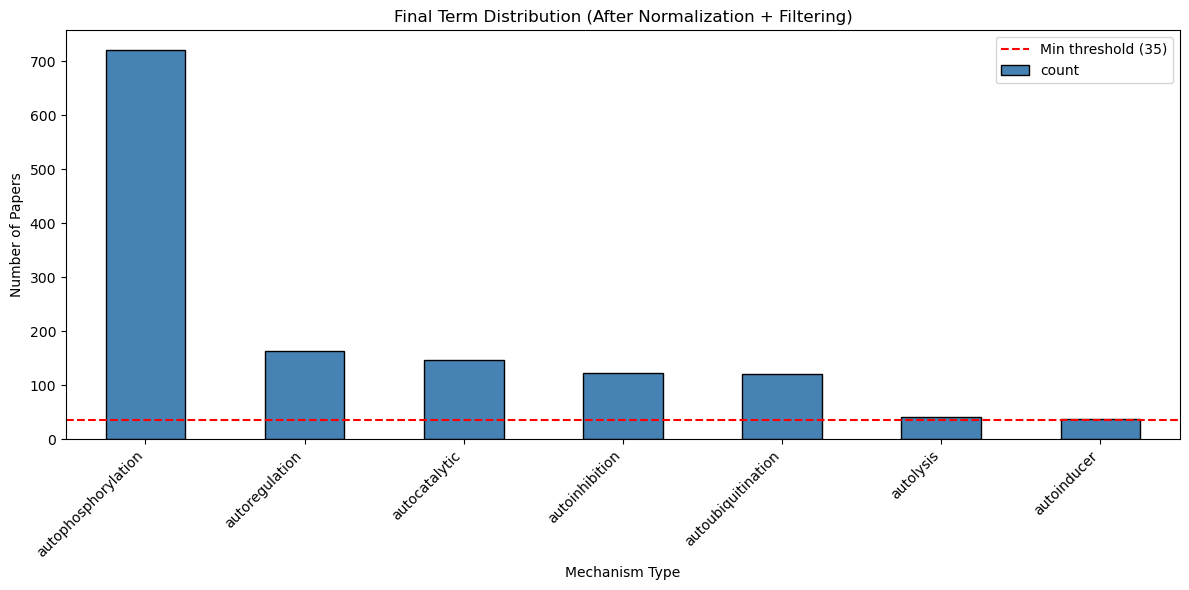


✓ Kept 7 terms
✓ Imbalance ratio: 19.0:1


In [36]:
# Final term counts
all_final_terms = []
for terms_str in df_final[df_final['has_mechanism_final']]['Terms_final']:
    if pd.notna(terms_str) and terms_str != '':
        all_final_terms.extend([t.strip() for t in str(terms_str).split(',')])

final_counts = pd.Series(all_final_terms).value_counts()

print("\n" + "="*50)
print("FINAL TERM DISTRIBUTION")
print("="*50)
print(final_counts)

# Plot
plt.figure(figsize=(12, 6))
final_counts.plot(kind='bar', color='steelblue', edgecolor='black')
plt.xlabel('Mechanism Type')
plt.ylabel('Number of Papers')
plt.title('Final Term Distribution (After Normalization + Filtering)')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=MIN_EXAMPLES, color='red', linestyle='--', 
            label=f'Min threshold ({MIN_EXAMPLES})')
plt.legend()
plt.tight_layout()
plt.show()

print(f"\n✓ Kept {len(final_counts)} terms")
print(f"✓ Imbalance ratio: {final_counts.max() / final_counts.min():.1f}:1")

In [37]:
# Create combined text column
df_final['text'] = (df_final['Title'].fillna('') + '. ' + 
                    df_final['Abstract'].fillna(''))

# Calculate text length
df_final['text_length'] = df_final['text'].str.len()

print("✓ Created text column")
print(f"Text length - Mean: {df_final['text_length'].mean():.0f}, "
      f"Median: {df_final['text_length'].median():.0f}")

✓ Created text column
Text length - Mean: 1348, Median: 1351


In [38]:
print("\n" + "="*50)
print("KEYWORD PRESENCE ANALYSIS")
print("="*50)

for term in final_counts.index:
    # Get papers with this term
    papers_with_term = df_final[df_final['Terms'].str.contains(
        term, case=False, na=False, regex=False
    )]
    
    # Check if term appears literally in text
    contains_literal = papers_with_term['text'].str.lower().str.contains(
        term.lower(), na=False, regex=False
    ).sum()
    
    percentage = (contains_literal / len(papers_with_term)) * 100
    
    print(f"{term:25} {contains_literal:4}/{len(papers_with_term):4} "
          f"({percentage:5.1f}%) contain term literally")

print("\n💡 Interpretation:")
print("  >80% = Keyword matching is strong baseline")
print("  40-80% = Need some semantic understanding")
print("  <40% = Need strong semantic inference!")


KEYWORD PRESENCE ANALYSIS
autophosphorylation        340/ 719 ( 47.3%) contain term literally
autoregulation             103/ 119 ( 86.6%) contain term literally
autocatalytic               55/ 133 ( 41.4%) contain term literally
autoinhibition              77/  84 ( 91.7%) contain term literally
autoubiquitination          17/ 121 ( 14.0%) contain term literally
autolysis                   40/  41 ( 97.6%) contain term literally
autoinducer                 31/  31 (100.0%) contain term literally

💡 Interpretation:
  >80% = Keyword matching is strong baseline
  40-80% = Need some semantic understanding
  <40% = Need strong semantic inference!


In [39]:
print("\n" + "="*50)
print("EXAMPLES: Papers WITHOUT the literal term")
print("="*50)

# Focus on the hardest case: autoubiquitination
autoub_papers = df_final[df_final['Terms'].str.contains(
    'autoubiquitination', case=False, na=False, regex=False
)]

# Find papers that DON'T contain the term
autoub_without_keyword = autoub_papers[
    ~autoub_papers['text'].str.lower().str.contains(
        'autoubiquitination', na=False, regex=False
    )
]

print(f"\nAutoubiquitination papers WITHOUT the term (need inference):")
print(f"Found: {len(autoub_without_keyword)} papers\n")

# Show 3 examples
for i, (idx, row) in enumerate(autoub_without_keyword.head(3).iterrows()):
    print(f"{'='*50}")
    print(f"Example {i+1}:")
    print(f"PMID: {row['PMID']}")
    print(f"Title: {row['Title'][:100]}...")
    print(f"Abstract snippet: {str(row['Abstract'])[:250]}...")
    print()


EXAMPLES: Papers WITHOUT the literal term

Autoubiquitination papers WITHOUT the term (need inference):
Found: 104 papers

Example 1:
PMID: 18382127
Title: CARPs enhance p53 turnover by degrading 14-3-3sigma and stabilizing MDM2....
Abstract snippet: CARP1 and CARP2 proteins (CARPs) are E3 ligases that target p53 as well as phospho-p53 for degradation. Because MDM2 is a critical regulator of p53 turnover, we investigated and found that CARPs associate with MDM2. We provide evidence that CARPs sta...

Example 2:
PMID: 15998807
Title: The AIP2 E3 ligase acts as a novel negative regulator of ABA signaling by promoting ABI3 degradation...
Abstract snippet: The phytohormone abscisic acid (ABA) mediates many complex aspects of plant development including seed maturation, dormancy, and germination as well as root growth. The B3-domain transcription factor abscisic acid-insensitive 3 (ABI3) is a central re...

Example 3:
PMID: 22508726
Title: The ubiquitin ligase mLin41 temporally promotes ne

In [40]:
df_final.columns.tolist()

['PMID',
 'Title',
 'Abstract',
 'Journal',
 'Authors',
 'Terms',
 'has_mechanism',
 'text',
 'text_length',
 'Terms_normalized',
 'has_mechanism_norm',
 'has_kept_term',
 'Terms_final',
 'has_mechanism_final']

In [41]:
df_final.head()

,PMID,Title,Abstract,Journal,Authors,Terms,has_mechanism,text,text_length,Terms_normalized,has_mechanism_norm,has_kept_term,Terms_final,has_mechanism_final
0,15165820,"Comparative genomic analyses of frog virus 3, ...",Frog virus 3 (FV3) is the type species member ...,Virology,"Wendy G H Tan, Todd J Barkman, V Gregory Chinc...",,False,"Comparative genomic analyses of frog virus 3, ...",971,,False,False,,False
1,16912294,Genome of invertebrate iridescent virus type 3...,Iridoviruses (IVs) are classified into five ge...,Journal of virology,"Gustavo Delhon, Edan R Tulman, Claudio L Afons...",,False,Genome of invertebrate iridescent virus type 3...,1970,,False,False,,False
2,11448171,Analysis of the first complete DNA sequence of...,"Chilo iridescent virus (CIV), the type species...",Virology,"N J Jakob, K Müller, U Bahr, G Darai",,False,Analysis of the first complete DNA sequence of...,2164,,False,False,,False
3,17239238,Comparative genomic analysis of the family Iri...,Members of the family Iridoviridae can cause s...,Virology journal,"Heather E Eaton, Julie Metcalf, Emily Penny, V...",,False,Comparative genomic analysis of the family Iri...,532,,False,False,,False
4,20633916,"Frog virus 3 ORF 53R, a putative myristoylated...",Although previous work identified 12 complemen...,Virology,"Dexter S Whitley, Kwang Yu, Robert C Sample, A...",,False,"Frog virus 3 ORF 53R, a putative myristoylated...",1151,,False,False,,False


In [42]:
# Keep only what you need for modeling
columns_to_keep = [
    'PMID',           # Identifier (for tracking, not modeling)
    'text',           # INPUT: Combined Title + Abstract (your features)
    'Terms_final',          # OUTPUT: Your labels (final normalized/filtered)
    'has_mechanism_final'   # Binary flag (labeled vs unlabeled)
]

# Create clean dataset
df_clean = df_final[columns_to_keep].copy()

In [43]:
df_clean

,PMID,text,Terms_final,has_mechanism_final
0,15165820,"Comparative genomic analyses of frog virus 3, ...",,False
1,16912294,Genome of invertebrate iridescent virus type 3...,,False
2,11448171,Analysis of the first complete DNA sequence of...,,False
3,17239238,Comparative genomic analysis of the family Iri...,,False
4,20633916,"Frog virus 3 ORF 53R, a putative myristoylated...",,False
...,...,...,...,...
262814,9557665,"Two RING finger proteins, the oncoprotein PML ...",,False
262815,10708446,The lymphocytic choriomeningitis virus RING pr...,,False
262816,11533204,RING finger Z protein of lymphocytic choriomen...,,False
262817,12050381,Characterization of the arenavirus RING finger...,,False


In [44]:
df_modeling = df_clean.rename(columns={
    'Terms_final': 'Terms',
    'has_mechanism_final': 'has_mechanism'
})

In [45]:
print("="*50)
print("FINAL MODELING DATASET")
print("="*50)
print(f"Shape: {df_modeling.shape}")
print(f"Columns: {df_modeling.columns.tolist()}")
print(f"\nLabeled papers: {df_modeling['has_mechanism'].sum()}")
print(f"Unlabeled papers: {(~df_modeling['has_mechanism']).sum()}")

# Verify terms
all_final_terms = []
for terms_str in df_modeling[df_modeling['has_mechanism']]['Terms']:
    if pd.notna(terms_str) and terms_str != '':
        all_final_terms.extend([t.strip() for t in str(terms_str).split(',')])

print(f"\nFinal term distribution:")
print(pd.Series(all_final_terms).value_counts())

# Save
df_modeling.to_csv('data/processed/modeling_dataset.csv', index=False)
print("\n✓ Saved to data/processed/modeling_dataset.csv")



FINAL MODELING DATASET
Shape: (254199, 4)
Columns: ['PMID', 'text', 'Terms', 'has_mechanism']

Labeled papers: 1334
Unlabeled papers: 252865

Final term distribution:
autophosphorylation    721
autoregulation         163
autocatalytic          147
autoinhibition         122
autoubiquitination     121
autolysis               41
autoinducer             38
Name: count, dtype: int64

✓ Saved to data/processed/modeling_dataset.csv


In [46]:
df_modeling

,PMID,text,Terms,has_mechanism
0,15165820,"Comparative genomic analyses of frog virus 3, ...",,False
1,16912294,Genome of invertebrate iridescent virus type 3...,,False
2,11448171,Analysis of the first complete DNA sequence of...,,False
3,17239238,Comparative genomic analysis of the family Iri...,,False
4,20633916,"Frog virus 3 ORF 53R, a putative myristoylated...",,False
...,...,...,...,...
262814,9557665,"Two RING finger proteins, the oncoprotein PML ...",,False
262815,10708446,The lymphocytic choriomeningitis virus RING pr...,,False
262816,11533204,RING finger Z protein of lymphocytic choriomen...,,False
262817,12050381,Characterization of the arenavirus RING finger...,,False
